In [298]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")


In [300]:
# importing and exploring the data 
df = pd.read_csv("PDB_Load_History.csv")
df.head(20)

,date,year,month,day,weekday,hour,demand,temperature
0,3/1/2003,2003,3,1,7,1,12863.0,29
1,3/1/2003,2003,3,1,7,2,12389.0,28
2,3/1/2003,2003,3,1,7,3,12155.0,29
3,3/1/2003,2003,3,1,7,4,12072.0,27
4,3/1/2003,2003,3,1,7,5,12160.0,29
5,3/1/2003,2003,3,1,7,6,12568.0,28
6,3/1/2003,2003,3,1,7,7,13236.0,29
7,3/1/2003,2003,3,1,7,8,14190.0,29
8,3/1/2003,2003,3,1,7,9,15213.0,28
9,3/1/2003,2003,3,1,7,10,15647.0,27


In [302]:
df.isnull().sum()

date           0
year           0
month          0
day            0
weekday        0
hour           0
demand         0
temperature    0
dtype: int64

In [304]:
df['date'] = pd.to_datetime(df['date'])

In [306]:
# ADF test to check if the data is stationary 
def check_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] < 0.05:
        print("Data is stationary (Reject H0)")
    else:
        print("Data is NOT stationary (Fail to reject H0)")

check_stationarity(df['demand'])

ADF Statistic: -15.5385
p-value: 0.0000
Data is stationary (Reject H0)


In [308]:
# creating lags for the XGBoost model 
num_lags = 7
for lag in range(1, num_lags + 1):
    df[f'demand_lag_{lag}'] = df['demand'].shift(lag)

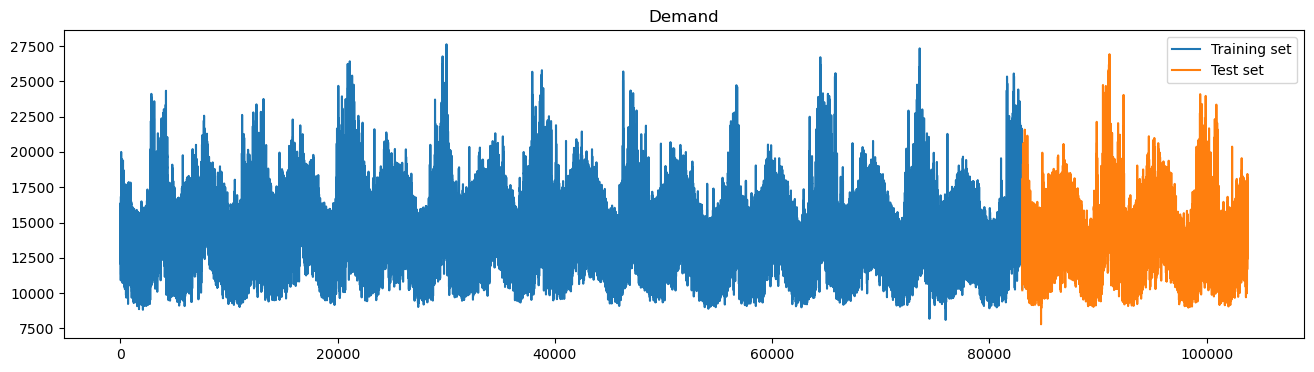

In [310]:
#splitting the data 
split_idx = int(len(df['demand']) * 0.8)
train_data = df[:split_idx]
test_data = df[split_idx:]
df["demand"][:split_idx].plot(figsize=(16,4),legend=True)
df["demand"][split_idx:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.title('Demand')
plt.show()

In [226]:
test_data.shape

(20756, 15)

In [228]:
train_data.shape

(83020, 15)

In [312]:
train_data = train_data.drop(['date'], axis=1)
test_data = test_data.drop(['date'], axis=1)

In [314]:
x_train = train_data.drop(columns='demand')
y_train = train_data['demand']
x_test = test_data.drop(columns='demand')
y_test = test_data['demand']

In [316]:
print('shape of X_train:', x_train.shape)
print('shape of X_test:', x_test.shape)
print('shape of y_train:', y_train.shape)
print('shape of y_test:', y_test.shape)

shape of X_train: (83020, 13)
shape of X_test: (20756, 13)
shape of y_train: (83020,)
shape of y_test: (20756,)


In [318]:
# training and evaluating the XGBoost model 
import xgboost as xgb
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(x_train, y_train)
predictions = model.predict(x_test)


In [320]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R-squared: {r2:.4f}')


MAE: 104.0788
RMSE: 177.2770
R-squared: 0.9959


In [322]:
# hyperparameter tuning 
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': np.arange(50, 300, 50),  
    'max_depth': np.arange(3, 10, 1), 
    'learning_rate': np.linspace(0.01, 0.3, 10),  
    'subsample': np.linspace(0.6, 1.0, 5),  
    'colsample_bytree': np.linspace(0.6, 1.0, 5) 
}
random_search = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_dist, 
    n_iter=10,  
    cv=5, 
    scoring='neg_mean_squared_error', 
    verbose=1, 
    random_state=42
)
random_search.fit(x_train, y_train)
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1711111111111111, 'colsample_bytree': 0.9}


In [324]:
# training a new model based on the hyperparams 
optimized_model = xgb.XGBRegressor(**best_params)
optimized_model.fit(x_train, y_train)
predictions = optimized_model.predict(x_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'Optimized RMSE: {rmse:.4f}')


Optimized RMSE: 171.5488


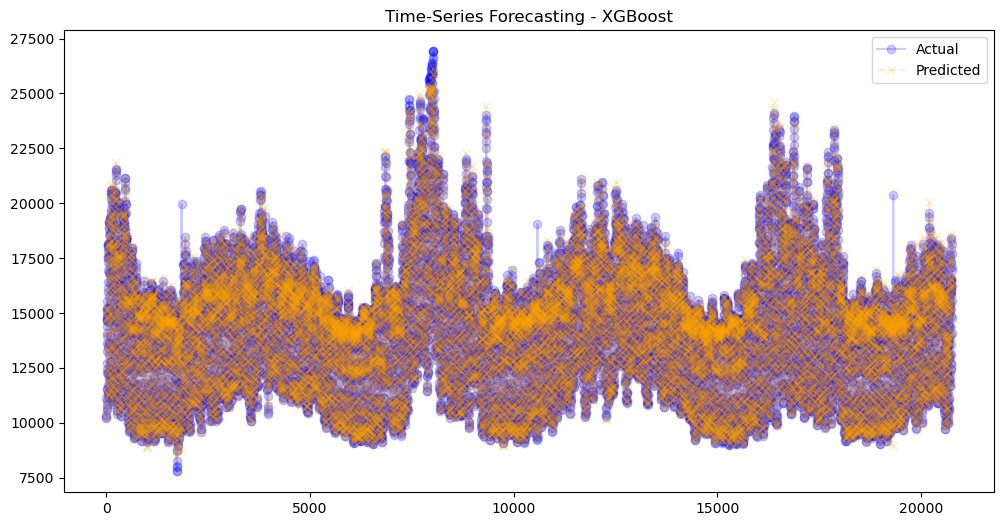

In [328]:
# checking the predicted values VS actual ones
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", marker='o', color = 'blue', alpha = 0.2)
plt.plot(predictions, label="Predicted", linestyle="dashed", marker='x', color="orange", alpha = 0.2)

plt.title("Time-Series Forecasting - XGBoost")
plt.legend()
plt.show()
